# Activations, Batch-norm and Gradients

Pytorch like implmentation of the model training. Deep dive on how initializations affect deeper network's activations and gradients.

[Lecture Link](https://www.youtube.com/watch?v=P6sfmUTpUmc)

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

## Load Data

In [14]:
# read in all the words
words = open('../names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [15]:
print(f"{len(words)=}")

len(words)=32033


## Helpers

In [16]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


## Build Dataset

In [17]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## Pytorch Layers: Linear & Batch-norm implementation

In [118]:
class Linear:
    def __init__(self, fan_in:int, fan_out:int, _generator:torch.Generator, bias:bool = True) -> None:
        self.W = torch.randn((fan_in,fan_out), generator=_generator) / fan_in**0.5
        self.b = torch.randn(fan_out, generator=_generator) if bias else None

    def __call__(self, x):
        self.out = x @ self.W
        if self.b is not None:
            self.out += self.b
        return self.out

    def parameters(self):
        return [self.W] + ([self.b] if self.b is not None else [])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with back-prop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with running-momentum update)
        self._running_mean = torch.zeros(dim)
        self._running_var = torch.ones(dim)

    def __call__(self, x):
        # forward-pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True, unbiased=True) # batch var
        else:
            xmean = self._running_mean
            xvar = self._running_var
        xhat = (x - xmean)/torch.sqrt(xvar + self.eps) # normalization  of batch
        self.out = self.gamma * xhat + self.beta

        # update buffers
        if self.training:
            with torch.no_grad():
                self._running_mean = (1-self.momentum) * self._running_mean + self.momentum * xmean
                self._running_var = (1-self.momentum) * self._running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

# Study of initialization impact on activations and gradients

## Deep Multi Layer Perceptron Model

In [119]:
vocab_size = 27
# block_size = 3
n_embed = 10 # dimensions of embedding
n_hidden = 100 # number of neurons in hidden layer
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embed), generator=g)
layers = [
    Linear(n_embed*block_size,  n_hidden, g), Tanh(),
    Linear(n_hidden,            n_hidden, g), Tanh(),
    Linear(n_hidden,            n_hidden, g), Tanh(),
    Linear(n_hidden,            n_hidden, g), Tanh(),
    Linear(n_hidden,            n_hidden, g), Tanh(),
    Linear(         n_hidden,   vocab_size, g)
]

# initializations
with torch.no_grad():
    # make last layer less confident
    layers[-1].W *= 0.1
    # apply kaiming init to other layers
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.W *= 5/3

parameters = [C] + [p  for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # total number of parameters

# set requries grad flag
for p in parameters:
    p.requires_grad = True

46497


## Training

In [120]:
max_steps = 200_000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # mini-batch
    ix = torch.randint(0,Xtr.shape[0], (batch_size,), generator=g)
    Xb,Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100_000 else 0.01 # learning rate with decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i%10_000 == 0:
        print(f"{i:7d}/{max_steps:7d}:{loss.item():4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std()/p.data.std()).log10().item()  for p in parameters])

    if i == 1000:
        break

      0/ 200000:3.815754


## Visualize the Activations

layer  1 (Tanh      ): mean -0.07, std 0.79, saturate: 26.34%
layer  3 (Tanh      ): mean +0.04, std 0.76, saturate: 21.12%
layer  5 (Tanh      ): mean +0.01, std 0.77, saturate: 19.81%
layer  7 (Tanh      ): mean -0.04, std 0.75, saturate: 17.16%
layer  9 (Tanh      ): mean -0.02, std 0.72, saturate: 13.81%


Text(0.5, 1.0, 'activation distribution')

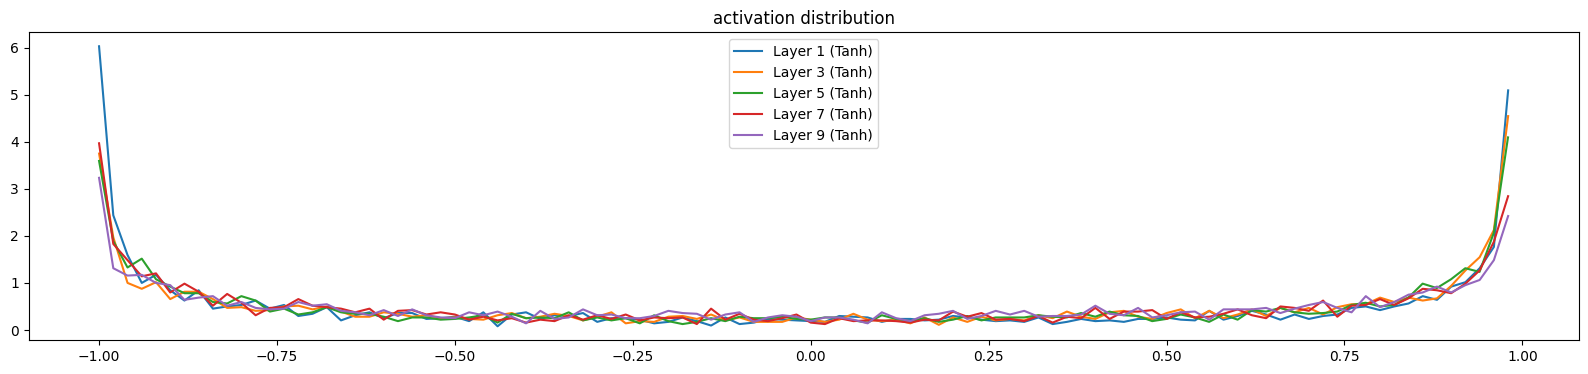

In [121]:
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]): # note exclude the ouptut layer
    if isinstance(layer, Tanh):
        t = layer.out
        # print('layer %d (%10s): mean %+.2f, std %.2f, saturate: %.2f%%' %(i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        print(f"layer {i:2d} ({layer.__class__.__name__:10s}): mean {t.mean():+.2f}, std {t.std():.2f}, saturate: {(t.abs()>0.97).float().mean()*100:.2f}%")
        hy,hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Layer {i} ({layer.__class__.__name__})')

plt.legend(legends)
plt.title('activation distribution')

## Visualize Gradients

layer  1 (Tanh      ): mean +0.000001, std 3.221493e-03
layer  3 (Tanh      ): mean -0.000008, std 3.100979e-03
layer  5 (Tanh      ): mean -0.000126, std 3.045853e-03
layer  7 (Tanh      ): mean -0.000003, std 2.920436e-03
layer  9 (Tanh      ): mean -0.000014, std 2.362769e-03


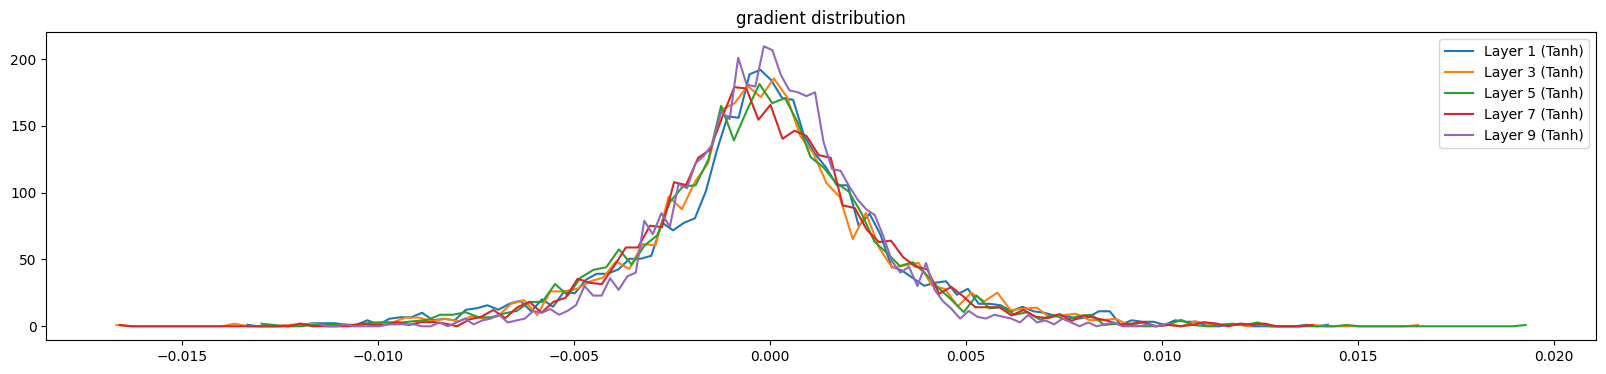

In [122]:
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]): # note exclude the ouptut layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        # print('layer %d (%10s): mean %+.2f, std %.2f, saturate: %.2f%%' %(i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        print(f"layer {i:2d} ({layer.__class__.__name__:10s}): mean {t.mean():+f}, std {t.std():e}")
        hy,hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Layer {i} ({layer.__class__.__name__})')

plt.legend(legends)
plt.title('gradient distribution');

## Visualize Weight Gradients

weight (27, 10)   | mean -0.000941, std 1.061679e-02 | grad:data 0.010570372454822063
weight (30, 100)  | mean +0.000170, std 9.515637e-03 | grad:data 0.030330156907439232
weight (100, 100) | mean +0.000050, std 7.791240e-03 | grad:data 0.04606939107179642
weight (100, 100) | mean +0.000046, std 7.396920e-03 | grad:data 0.0441485270857811
weight (100, 100) | mean +0.000019, std 6.920897e-03 | grad:data 0.04106411337852478
weight (100, 100) | mean +0.000042, std 6.245552e-03 | grad:data 0.03706330060958862
weight (100, 27)  | mean -0.000000, std 2.457608e-02 | grad:data 0.3523217439651489


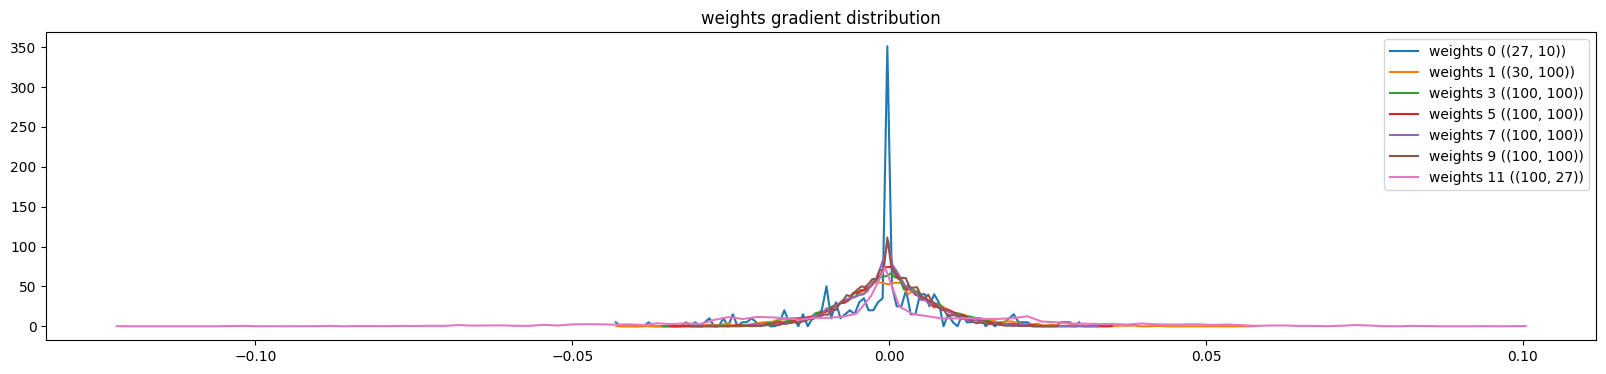

In [123]:
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print(f"weight {str(tuple(p.shape)):10s} | mean {t.mean():+f}, std {t.std():e} | grad:data {t.std()/p.std()}")
        hy,hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'weights {i} ({tuple(p.shape)})')

plt.legend(legends)
plt.title('weights gradient distribution');

## Update to data distribution

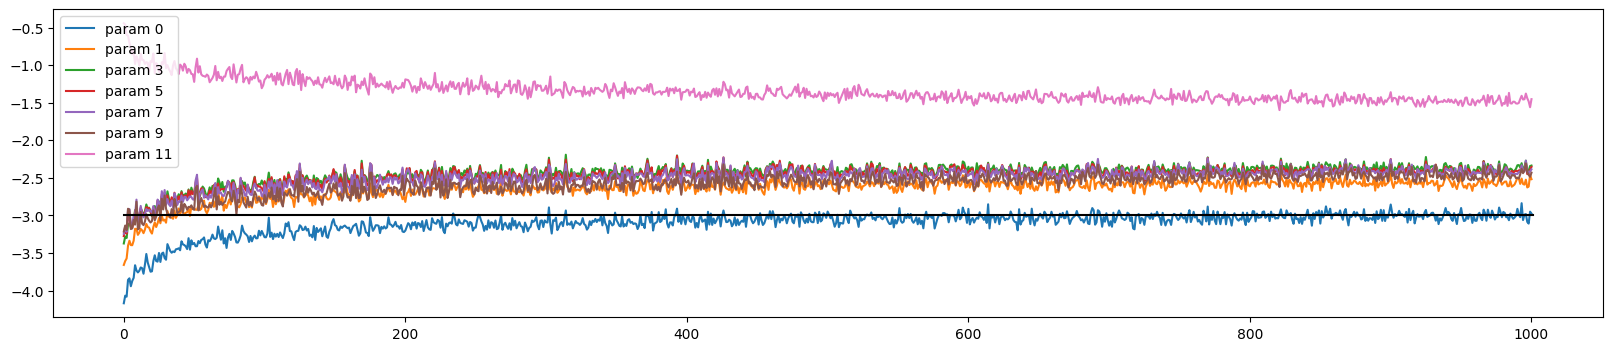

In [132]:
plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f'param {i}')

plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3 
plt.legend(legends);

The update to data distribution plot gives a sense whether the model is able to properly learn parameters. Ideally update to data ratio should be `1e-3`, so we expect all the ratios to be closely either above or below the `1e-3` black line.

In the graph paramters of last layer are much higher because we initialized the parameters of the layer with lower values (multiplied by 0.1) so that model is less confident on the ouput, so it thinks all values are equally likely. This is why this layer gets huge updates but eventually it will also converge to `1e-3`. 

## Effect of initialization gain on activations and gradients

### Case 1: Gain = 5/3  ([Pytorch](https://docs.pytorch.org/docs/stable/nn.init.html#torch.nn.init.calculate_gain) recommended)

We get healthier distribution of activations in forward pass and gradients in backward pass 

![Ideal activations](activation_ideal.png)

Distribution of activations of layers is very similar.

![Ideal gradients](gradients_ideal.png)

The gradients of all layers are similar in magnitude


### Case 2: Gain = 1 (lower gain)

![Low activations](activation_low.png)

Distribution of activations of layers is very similar and healthy.

![Low gradients](gradients_low.png)

Gradients starts very high in initial layers and it difusses out at the later layers. This is very bad for a model as the later layers gets very low gradients and does not train well.

### Case 3: Gain = 5 (high gain)

![High activations](activation_high.png)

The distribution of activations is very poor and very highly concentrated on the tails. Most of the neurons are highly saturated

![High gradients](gradients_high.png)

The magnitude of gradient distribution increases towards later layers. A very small pertubation might lead to big change in output. This leads to very unstable training. 

# Batch Normalization

Analysis of effect of initialization with batch-norm layer

## Deep Multi Layer Perceptron Model

In [138]:
from torch_geometric.nn import BatchNorm


vocab_size = 27
# block_size = 3
n_embed = 10 # dimensions of embedding
n_hidden = 100 # number of neurons in hidden layer
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embed), generator=g)
layers = [
    Linear(n_embed*block_size,  n_hidden, g), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,            n_hidden, g), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,            n_hidden, g), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,            n_hidden, g), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,            n_hidden, g), BatchNorm1d(n_hidden), Tanh(),
    Linear(       n_hidden,   vocab_size, g), BatchNorm1d(vocab_size)
]

# initializations
with torch.no_grad():
    # make last layer less confident
    # layers[-1].W *= 0.1
    layers[-1].gamma *= 0.1
    # apply kaiming init to other layers
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.W *= 5/3

parameters = [C] + [p  for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # total number of parameters

# set requries grad flag
for p in parameters:
    p.requires_grad = True

47551


## Training

In [139]:
max_steps = 200_000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # mini-batch
    ix = torch.randint(0,Xtr.shape[0], (batch_size,), generator=g)
    Xb,Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100_000 else 0.01 # learning rate with decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i%10_000 == 0:
        print(f"{i:7d}/{max_steps:7d}:{loss.item():4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std()/p.data.std()).log10().item()  for p in parameters])

    if i == 1000:
        break

      0/ 200000:3.306318


## Visualize the Activations

layer  2 (Tanh      ): mean -0.01, std 0.63, saturate: 2.72%
layer  5 (Tanh      ): mean -0.01, std 0.64, saturate: 2.41%
layer  8 (Tanh      ): mean -0.00, std 0.64, saturate: 2.84%
layer 11 (Tanh      ): mean -0.00, std 0.64, saturate: 2.00%
layer 14 (Tanh      ): mean -0.00, std 0.65, saturate: 1.72%


Text(0.5, 1.0, 'activation distribution')

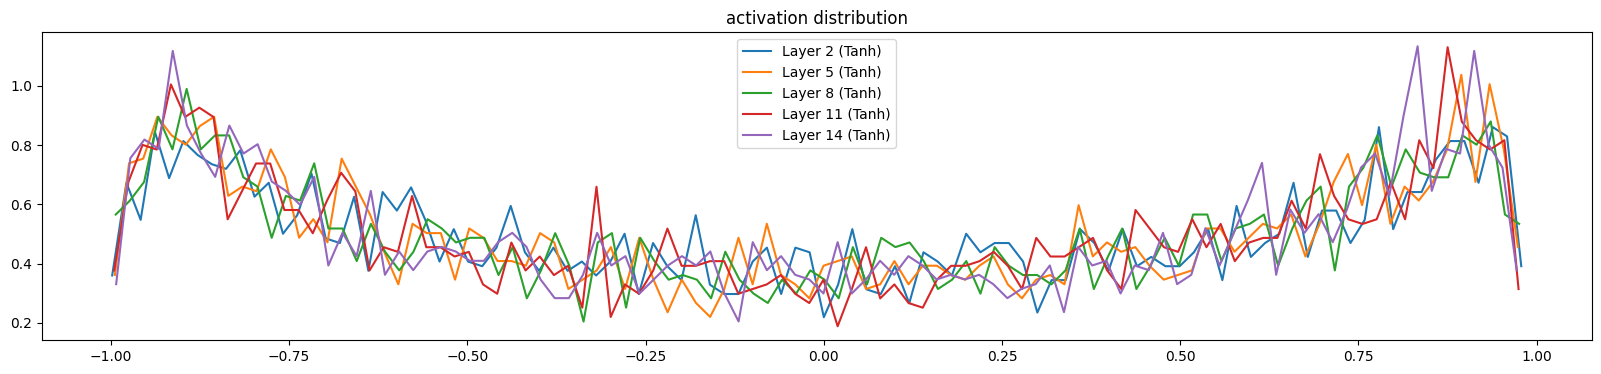

In [140]:
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]): # note exclude the ouptut layer
    if isinstance(layer, Tanh):
        t = layer.out
        # print('layer %d (%10s): mean %+.2f, std %.2f, saturate: %.2f%%' %(i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        print(f"layer {i:2d} ({layer.__class__.__name__:10s}): mean {t.mean():+.2f}, std {t.std():.2f}, saturate: {(t.abs()>0.97).float().mean()*100:.2f}%")
        hy,hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Layer {i} ({layer.__class__.__name__})')

plt.legend(legends)
plt.title('activation distribution')

## Visualize Gradients

layer  2 (Tanh      ): mean -0.000000, std 3.221283e-03
layer  5 (Tanh      ): mean -0.000000, std 2.772040e-03
layer  8 (Tanh      ): mean -0.000000, std 2.513541e-03
layer 11 (Tanh      ): mean +0.000000, std 2.298571e-03
layer 14 (Tanh      ): mean -0.000000, std 2.131352e-03


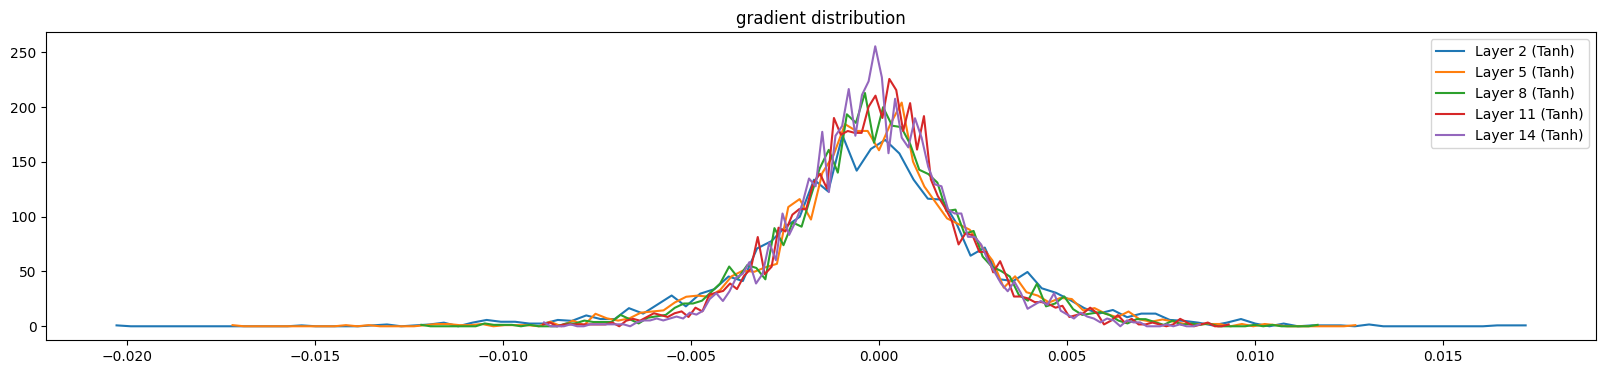

In [141]:
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]): # note exclude the ouptut layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        # print('layer %d (%10s): mean %+.2f, std %.2f, saturate: %.2f%%' %(i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        print(f"layer {i:2d} ({layer.__class__.__name__:10s}): mean {t.mean():+f}, std {t.std():e}")
        hy,hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Layer {i} ({layer.__class__.__name__})')

plt.legend(legends)
plt.title('gradient distribution');

## Visualize Weight Gradients

weight (27, 10)   | mean +0.000000, std 9.090067e-03 | grad:data 0.009081052616238594
weight (30, 100)  | mean -0.000182, std 7.550435e-03 | grad:data 0.02415808103978634
weight (100, 100) | mean +0.000074, std 6.408168e-03 | grad:data 0.03819683939218521
weight (100, 100) | mean -0.000040, std 5.832816e-03 | grad:data 0.035109035670757294
weight (100, 100) | mean -0.000059, std 5.069716e-03 | grad:data 0.030331382527947426
weight (100, 100) | mean +0.000003, std 4.541588e-03 | grad:data 0.02709418348968029
weight (100, 27)  | mean -0.000289, std 8.517975e-03 | grad:data 0.05090978741645813


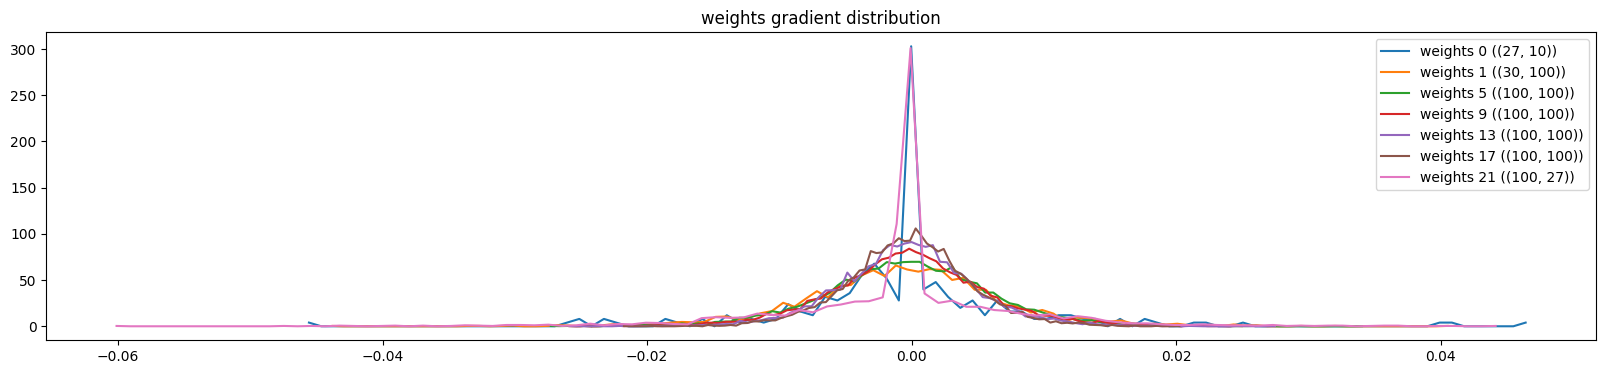

In [142]:
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print(f"weight {str(tuple(p.shape)):10s} | mean {t.mean():+f}, std {t.std():e} | grad:data {t.std()/p.std()}")
        hy,hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'weights {i} ({tuple(p.shape)})')

plt.legend(legends)
plt.title('weights gradient distribution');

## Update to data distribution

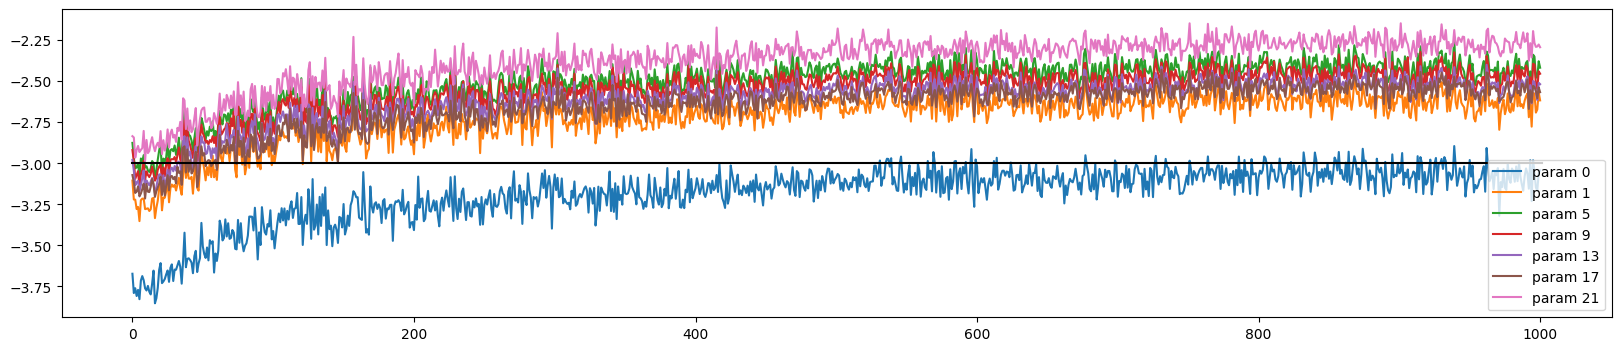

In [143]:
plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f'param {i}')

plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3 
plt.legend(legends);

The batch-normalization layer effectively nullifies the sensitivity of model to initializations. Even if the model's weights are poorly initialized the batch-normalization layer balances it and results in very nice distribution of gradients, activations and weight gradients.

Note: One point to take care is, the batch normalization may not effect update data ratio distribution. When the initializations are scaled to very small values it would result in huge updates in order of `1e-2`. This can be mitigated by setting higher learning rates.